

---


# 🚑🚒 **Classificando Sons de Veículos de Emergência** 🚑🚒

Ana Ellen Deodato P Silva		 						800206  
Vinicius de Oliveira Guimarães 							802431  
Vinícius Gonçalves Perillo 								800219  



---


# 📊 **Dados das imagens** 📊

Olhando os arquivos, temos para:

* **Treino**: 1600 imagens, 800 de cada espécie
* **Validação**: 414 imagens, 207 de cada espécie
* **Teste**: 5 imagens de coelhos e 10 de gatos


### Importação das imagens

In [1]:
# Common
import os
import shutil
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

#Data Import
import kagglehub


# Sound Processing
import librosa

# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px



In [2]:


# Download latest version
path = kagglehub.dataset_download("vishnu0399/emergency-vehicle-siren-sounds")

print("Path to dataset files:", path)

shutil.move(path, './')
os.rename('./' + path.split('/')[-1], './data')

100%|██████████| 282M/282M [00:13<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vishnu0399/emergency-vehicle-siren-sounds/versions/4


In [3]:
for folder in ('ambulance', 'firetruck', 'traffic'):
    for fil in os.listdir(os.path.join('./data/sounds/', folder)):
        if fil.endswith('.png') or fil.endswith('.py'):
            path = './data/sounds/' + folder + "/" + fil
            os.remove(path)

In [4]:
root = './data/sounds/'

ambulance_sounds_paths = os.listdir(os.path.join(root,'ambulance/'))
firetruck_sounds_paths = os.listdir(os.path.join(root, 'firetruck/'))
traffic_sounds_paths = os.listdir(os.path.join(root, 'traffic/'))


In [5]:
amb_sounds = []
fir_sounds = []
tra_sounds = []

for s in ambulance_sounds_paths:
    y, sr = librosa.load(os.path.join(root, 'ambulance/', s))
    amb_sounds.append((y, sr, 'ambulance'))

for s in firetruck_sounds_paths:
    y, sr = librosa.load(os.path.join(root, 'firetruck/', s))
    fir_sounds.append((y, sr, 'firetruck'))

for s in traffic_sounds_paths:
    y, sr = librosa.load(os.path.join(root, 'traffic/', s))
    tra_sounds.append((y, sr, 'traffic'))

In [6]:
amb_sounds = np.array(amb_sounds, dtype=object)
fir_sounds = np.array(fir_sounds, dtype=object)
tra_sounds = np.array(tra_sounds, dtype=object)



---


# 📈 **Pré Processamento** 📈

In [7]:
amb_train, amb_test = np.split(np.random.permutation(amb_sounds), [150])
fir_train, fir_test = np.split(np.random.permutation(fir_sounds), [150])
tra_train, tra_test = np.split(np.random.permutation(tra_sounds), [150])

## Aumento dos Dados

### Pink Noise


In [8]:
def generate_pink_noise(duration_sec, sample_rate):
    num_samples = int(duration_sec * sample_rate)
    pink_noise = np.random.randn(num_samples)
    pink_noise = np.cumsum(pink_noise)
    pink_noise -= np.mean(pink_noise)
    pink_noise /= np.max(np.abs(pink_noise))

    return pink_noise

def apply_pink_noise(audio, sr, lable):
    pink_noise = generate_pink_noise(len(audio) / sr, sr)
    pink_noise = pink_noise[:len(audio)]
    mixed_audio = audio + 0.5 * pink_noise

    return (mixed_audio, sr, label)

In [9]:
amb_pink = []
fir_pink = []
tra_pink = []

for audio, sr, label in np.random.permutation(amb_train)[:50]:
    amb_pink.append(apply_pink_noise(audio, sr, label))

for audio, sr, label in np.random.permutation(fir_train)[:50]:
    fir_pink.append(apply_pink_noise(audio, sr, label))

for audio, sr, label in np.random.permutation(tra_train)[:50]:
    tra_pink.append(apply_pink_noise(audio, sr, label))


In [10]:
len(amb_pink)

50

### Gaussian Noise

In [11]:
def apply_gaussian_noise(audio, sr, label):
    gaussian_noise = np.random.normal(0, 0.005, len(audio))
    mixed_audio = audio + gaussian_noise

    return (mixed_audio, sr, label)

In [12]:
amb_gaussian = []
fir_gaussian = []
tra_gaussian = []

for audio, sr, label in np.random.permutation(amb_train)[:50]:
    amb_gaussian.append(apply_gaussian_noise(audio, sr, label))

for audio, sr, label in np.random.permutation(fir_train)[:50]:
    fir_gaussian.append(apply_gaussian_noise(audio, sr, label))

for audio, sr, label in np.random.permutation(tra_train)[:50]:
    tra_gaussian.append(apply_gaussian_noise(audio, sr, label))

### Gain/Random power

In [13]:
def apply_gain(audio, sr, label):
    mixed_audio = audio * np.random.uniform(0.5, 1.5)

    return (mixed_audio, sr, label)

In [14]:
amb_gain = []
fir_gain = []
tra_gain = []

for audio, sr, label in np.random.permutation(amb_train)[:50]:
    amb_gain.append(apply_gain(audio, sr, label))

for audio, sr, label in np.random.permutation(fir_train)[:50]:
    fir_gain.append(apply_gain(audio, sr, label))

for audio, sr, label in np.random.permutation(tra_train)[:50]:
    tra_gain.append(apply_gain(audio, sr, label))



### TanH Distortion

In [15]:
def apply_tanh_distortion(audio, sr, label):
    distorted_audio = np.tanh(2 * audio)
    distorted_audio /= np.max(np.abs(distorted_audio))

    return (distorted_audio, sr, label)

In [16]:
amb_tanh = []
fir_tanh = []
tra_tanh = []

for audio, sr, label in np.random.permutation(amb_train)[:50]:
    amb_tanh.append(apply_tanh_distortion(audio, sr, label))

for audio, sr, label in np.random.permutation(fir_train)[:50]:
    fir_tanh.append(apply_tanh_distortion(audio, sr, label))

for audio, sr, label in np.random.permutation(tra_train)[:50]:
    tra_tanh.append(apply_tanh_distortion(audio, sr, label))

### Adicionando ao conjunto teste

In [17]:
amb_train = np.concatenate([amb_train, np.array(amb_pink, dtype= object)])
fir_train = np.concatenate([fir_train, np.array(fir_pink, dtype= object)])
tra_train = np.concatenate([tra_train, np.array(tra_pink, dtype= object)])

In [18]:
amb_train = np.concatenate([amb_train, np.array(amb_gaussian, dtype= object)])
fir_train = np.concatenate([fir_train, np.array(fir_gaussian, dtype= object)])
tra_train = np.concatenate([tra_train, np.array(tra_gaussian, dtype= object)])

In [19]:
amb_train = np.concatenate([amb_train, np.array(amb_gain, dtype= object)])
fir_train = np.concatenate([fir_train, np.array(fir_gain, dtype= object)])
tra_train = np.concatenate([tra_train, np.array(tra_gain, dtype= object)])

In [20]:
#amb_train = np.concatenate([amb_train, np.array(amb_tanh, dtype= object)])
#fir_train = np.concatenate([fir_train, np.array(fir_tanh, dtype= object)])
#tra_train = np.concatenate([tra_train, np.array(tra_tanh, dtype= object)])

## Mel Espectograma

In [21]:
train = np.concatenate([amb_train, fir_train, tra_train])
test = np.concatenate([amb_test, fir_test, tra_test])



In [22]:
def get_melspec(inp: tuple):
    y, sr, _ = inp

    mel_spec = librosa.feature.melspectrogram(y= y, sr= sr, hop_length= 1024)
    mel_spec[mel_spec == 0] = np.finfo(float).eps
    mel_spec = np.log(mel_spec)

    return mel_spec


In [23]:
train_mel = []
test_mel = []

for i in train:
    train_mel.append(get_melspec(i))


for i in test:
    test_mel.append(get_melspec(i))

In [24]:
train_df = pd.DataFrame(train, columns= ['y','sr','label'])
train_df['mel'] = train_mel
test_df = pd.DataFrame(test, columns= ['y','sr','label'])
test_df['mel'] = test_mel

In [25]:
train_df['label'] = train_df['label'].map({'ambulance': 0, 'firetruck': 1, 'traffic': 2})
test_df['label'] = test_df['label'].map({'ambulance': 0, 'firetruck': 1, 'traffic': 2})

In [26]:
train_df = train_df.sample(frac=1.0)
test_df = test_df.sample(frac=1.0)

In [27]:
train_df.head()

,y,sr,label,mel
830,"[0.034785845984562504, 0.052692706080486526, 0...",22050,2,"[[2.3895581819662146, 1.6769637969967959, 1.17..."
318,"[-0.04211478, 0.29274356, 0.7318151, 0.6704078...",22050,1,"[[-1.8223482, -5.244711, -4.8241878, -5.627522..."
757,"[0.5170407313265124, 0.5412589072574496, 0.552...",22050,2,"[[7.11292424434882, 6.894131744541091, 6.89608..."
855,"[0.049961403, 0.08499657, 0.08958119, 0.101638...",22050,2,"[[-0.5962153, -0.029512834, 1.7585495, 3.25958..."
409,"[0.11417408, 0.19538009, 0.025743872, -0.01665...",22050,1,"[[-3.9050162, -1.6246635, -0.78410554, 0.61479..."


### Uma amostra

In [28]:
class_names = ['ambulance', 'firetruck', 'traffic']

In [29]:
def show_images(images:list, labels:list, class_names:list, model:None = None, GRID:tuple = (5,6), SIZE:tuple = (30,25)) -> None:
    # Plotting Configuration
    plt.figure(figsize=SIZE)
    n_rows, n_cols = GRID[0], GRID[1]
    n_images = n_rows * n_cols

    # Iterate through the Plot
    for i in range(1, n_images+1):
        # Select image & label randomly
        index = np.random.randint(len(images))
        image, label = images[index], labels[index]
        title = class_names[int(label)]

        # Plot the Image
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(tf.squeeze(image))
        plt.title(title.title())
        plt.axis('off')

    # Show Final Figure
    plt.show()

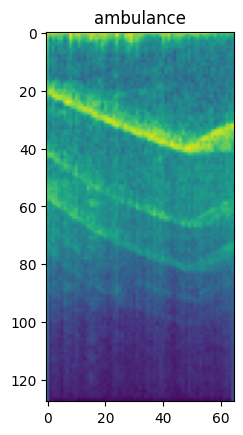

(128, 65)


In [30]:
i = np.random.randint(1050)

plt.figure()
plt.imshow(np.array(train_df['mel'][i]))
plt.title(class_names[train_df['label'][i]])
plt.show()

print(train_df['mel'][i].shape)



---


# 🌐 **Aplicação dos Modelos** 🌐

In [31]:
def reshape_and_norm(imagem):
    img = (imagem - imagem.min()) / (imagem.max() - imagem.min())
    return img[:,:65].reshape((128,65,1))


In [32]:
train_df['mel'] = train_df['mel'].apply(reshape_and_norm)
test_df['mel'] = test_df['mel'].apply(reshape_and_norm)


### Redes Neurais Convolucionais

In [33]:
def def_model():
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=(128,65,1)))
    model.add(keras.layers.MaxPooling2D(pool_size=[2,2], strides=2))
    model.add(keras.layers.BatchNormalization())


    model.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=[2,2], strides=2))
    model.add(keras.layers.BatchNormalization())


    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=[2,2], strides=2))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=[2,2], strides=2))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.33))
    model.add(keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model




In [34]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=12),
    keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience=5, min_lr=0.00001),
    keras.callbacks.ModelCheckpoint(
        save_best_only= True,
        filepath= 'best_model.keras'
    )
]
model = def_model()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 65, 32)         │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 8, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 8, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,815,747 (33.63 MB)

 Trainable params: 8,814,787 (33.63 MB)

 Non-trainable params: 960 (3.75 KB)

In [35]:
history = model.fit(
    np.array(train_df['mel'].to_list()),
    np.array(train_df['label'].to_list()),
    epochs=100,
    validation_split=0.2,
    callbacks= callbacks,
    batch_size= 15,
)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.6926 - loss: 3.4925 - val_accuracy: 0.3778 - val_loss: 5.8998 - learning_rate: 0.0010
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8874 - loss: 0.8655 - val_accuracy: 0.3500 - val_loss: 11.5677 - learning_rate: 0.0010
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9247 - loss: 0.4259 - val_accuracy: 0.3500 - val_loss: 7.7599 - learning_rate: 0.0010
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9559 - loss: 0.1452 - val_accuracy: 0.3500 - val_loss: 23.2199 - learning_rate: 0.0010
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9539 - loss: 0.2836 - val_accuracy: 0.3944 - val_loss: 27.4129 - learning_rate: 0.0010
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9113 - loss: 0.6435 - val_accuracy: 0.6333 - val_loss: 2.4135 - learning_rate: 0.0010
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9734 - loss: 0.1035

In [36]:
import plotly.express as px
import pandas as pd

his = pd.DataFrame(history.history)
melt = pd.melt(his, ignore_index= False)


In [37]:
acc = melt[(melt['variable'] == 'accuracy') | (melt['variable'] == 'val_accuracy')]
loss = melt[(melt['variable'] == 'loss') | (melt['variable'] == 'val_loss')]

In [38]:
fig = px.line(acc, y='value', color= 'variable')

fig.show()

In [39]:
fig = px.line(loss, y='value', color= 'variable')

fig.show()

In [40]:
model = keras.models.load_model('best_model.keras')

In [41]:
test_loss, test_acc = model.evaluate(np.array(test_df['mel'].to_list()), np.array(test_df['label'].to_list()))

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.9764 - loss: 0.1121


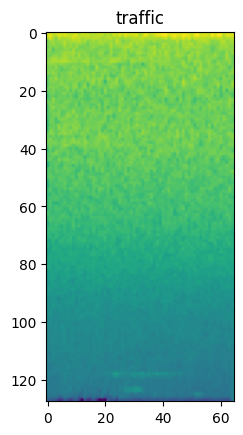

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


<Figure size 640x480 with 0 Axes>

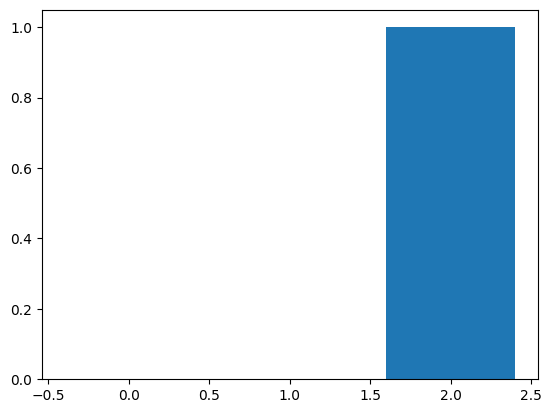

In [42]:
i = 150
i = np.random.randint(150)

plt.figure()
plt.imshow(test_df['mel'][i])
plt.title(class_names[test_df['label'][i]])
plt.show()

plt.figure()
predictions = model.predict(np.expand_dims(test_df['mel'][i], axis=0)).squeeze()
categories = np.arange(len(predictions))
plt.figure()
plt.bar(categories, predictions)
plt.show()

### LSTM

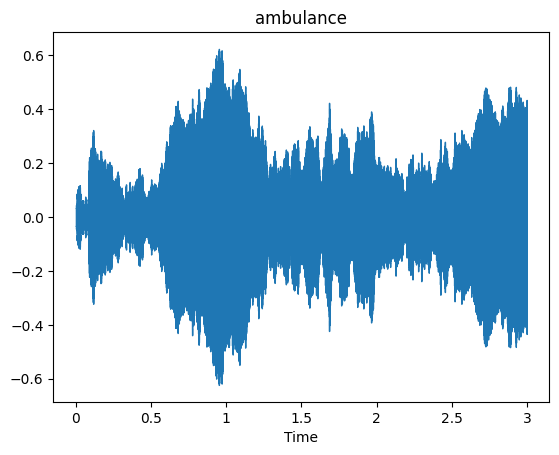

(66150,)


In [43]:
i = np.random.randint(1050)

plt.figure()
librosa.display.waveshow(train_df['y'][i], sr=train_df['sr'][i])
plt.title(class_names[train_df['label'][i]])
plt.show()

print(train_df['y'][i].shape)

In [44]:
train_df['y'].apply(lambda x: x.shape).unique()

array([(66150,), (66327,), (66560,)], dtype=object)

In [45]:
def reshape_and_norm(imagem):
    img = (imagem - imagem.min()) / (imagem.max() - imagem.min())
    return img[:66150]

In [46]:
train_df['y'] = train_df['y'].apply(reshape_and_norm)
test_df['y'] = test_df['y'].apply(reshape_and_norm)

In [50]:
def def_lstm():
    model = keras.Sequential()

    model.add(keras.layers.AveragePooling1D(pool_size=20, input_shape=(66150, 1)))
    model.add(keras.layers.LSTM(64, activation='tanh', input_shape=(66150, 1)))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.4))

    model.add(keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

In [51]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=12),
    keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience=5, min_lr=0.00001),
    keras.callbacks.ModelCheckpoint(
        save_best_only= True,
        filepath= 'best_model.keras'
    )
]
model = def_lstm()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/pooling/base_pooling.py:23: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ average_pooling1d (AveragePooling1D) │ (None, 3307, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,235 (90.76 KB)

 Trainable params: 23,235 (90.76 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
history = model.fit(
    np.array(train_df['y'].to_list()),
    np.array(train_df['label'].to_list()),
    epochs=100,
    validation_split=0.2,
    callbacks= callbacks,
    batch_size= 30,
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.3276 - loss: 1.0988 - val_accuracy: 0.3222 - val_loss: 1.0999 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.3252 - loss: 1.0989 - val_accuracy: 0.3167 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.2877 - loss: 1.0999 - val_accuracy: 0.3167 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.3582 - loss: 1.0973 - val_accuracy: 0.3278 - val_loss: 1.0988 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.3237 - loss: 1.0988 - val_accuracy: 0.3167 - val_loss: 1.0995 - learning_rate: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.3539 - loss: 1.0974 - val_accuracy: 0.3222 - val_loss: 1.0993 - learning_rate: 0.0010
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.3203 - loss: 1.1003

In [53]:


his = pd.DataFrame(history.history)
melt = pd.melt(his, ignore_index= False)


In [54]:
acc = melt[(melt['variable'] == 'accuracy') | (melt['variable'] == 'val_accuracy')]
loss = melt[(melt['variable'] == 'loss') | (melt['variable'] == 'val_loss')]

In [55]:
fig = px.line(acc, y='value', color= 'variable')

fig.show()

In [56]:
fig = px.line(loss, y='value', color= 'variable')

fig.show()

In [61]:
test_loss, test_acc = model.evaluate(np.array(test_df['y'].to_list()), np.array(test_df['label'].to_list()))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3729 - loss: 1.0978


acuracia de uma rede aleatória


In [62]:
def def_lstm():
    model = keras.Sequential()

    model.add(keras.layers.Conv1D(filters=32, kernel_size=23, padding='same', activation='relu', input_shape=(66150, 1)))
    model.add(keras.layers.MaxPooling1D(pool_size=16, strides=16))
    model.add(keras.layers.BatchNormalization())


    model.add(keras.layers.Conv1D(filters=64, kernel_size=23, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=16, strides=16))
    model.add(keras.layers.BatchNormalization())


    model.add(keras.layers.Conv1D(filters=128, kernel_size=23, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=16, strides=16))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.LSTM(64, activation= 'tanh'))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    model.summary()

    return model


In [63]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=12),
    keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience=5, min_lr=0.00001),
    keras.callbacks.ModelCheckpoint(
        save_best_only= True,
        filepath= 'best_model.keras'
    )
]
model = def_lstm()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 66150, 32)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 4134, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4134, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 4134, 64)            │          47,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 258, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 258, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 258, 128)            │         188,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 286,979 (1.09 MB)

 Trainable params: 286,531 (1.09 MB)

 Non-trainable params: 448 (1.75 KB)

In [64]:
history = model.fit(
    np.array(train_df['y'].to_list()),
    np.array(train_df['label'].to_list()),
    epochs=100,
    validation_split=0.2,
    callbacks= callbacks,
    batch_size= 15,
)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7406 - loss: 0.5783 - val_accuracy: 0.5389 - val_loss: 1.9631 - learning_rate: 0.0010
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8928 - loss: 0.3171 - val_accuracy: 0.4889 - val_loss: 2.0565 - learning_rate: 0.0010
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9109 - loss: 0.2372 - val_accuracy: 0.3278 - val_loss: 2.4683 - learning_rate: 0.0010
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9022 - loss: 0.2761 - val_accuracy: 0.5833 - val_loss: 2.2742 - learning_rate: 0.0010
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9163 - loss: 0.2394 - val_accuracy: 0.3222 - val_loss: 3.4636 - learning_rate: 0.0010
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9241 - loss: 0.1966 - val_accuracy: 0.3278 - val_loss: 3.2626 - learning_rate: 0.0010
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9246 - loss: 0.1985 - 

In [65]:
import plotly.express as px
import pandas as pd

his = pd.DataFrame(history.history)
melt = pd.melt(his, ignore_index= False)


In [66]:
acc = melt[(melt['variable'] == 'accuracy') | (melt['variable'] == 'val_accuracy')]
loss = melt[(melt['variable'] == 'loss') | (melt['variable'] == 'val_loss')]

In [67]:
fig = px.line(acc, y='value', color= 'variable')

fig.show()

In [68]:
fig = px.line(loss, y='value', color= 'variable')

fig.show()

In [69]:
model = keras.models.load_model('best_model.keras')

In [70]:
test_loss, test_acc = model.evaluate(np.array(test_df['y'].to_list()), np.array(test_df['label'].to_list()))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9615 - loss: 0.1311


In [71]:
def def_lstm():
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=(128,65,1)))
    model.add(keras.layers.MaxPooling2D(pool_size=[2,2], strides=2))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=[2,2], strides=2))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=[32,2], strides=2))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Reshape([8,128]))

    model.add(keras.layers.LSTM(64, activation= 'tanh'))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    model.summary()

    return model


In [72]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=12),
    keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience=5, min_lr=0.00001),
    keras.callbacks.ModelCheckpoint(
        save_best_only= True,
        filepath= 'best_model.keras'
    )
]
model = def_lstm()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 65, 32)         │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 1, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 176,451 (689.26 KB)

 Trainable params: 176,003 (687.51 KB)

 Non-trainable params: 448 (1.75 KB)

In [73]:
history = model.fit(
    np.array(train_df['mel'].to_list()),
    np.array(train_df['label'].to_list()),
    epochs=100,
    validation_split=0.2,
    callbacks= callbacks,
    batch_size= 15,
)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8367 - loss: 0.4374 - val_accuracy: 0.3278 - val_loss: 2.0179 - learning_rate: 0.0010
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9588 - loss: 0.1302 - val_accuracy: 0.3278 - val_loss: 2.5592 - learning_rate: 0.0010
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9449 - loss: 0.1254 - val_accuracy: 0.3278 - val_loss: 2.0333 - learning_rate: 0.0010
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9418 - loss: 0.1506 - val_accuracy: 0.3278 - val_loss: 2.1756 - learning_rate: 0.0010
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9618 - loss: 0.0877 - val_accuracy: 0.3278 - val_loss: 2.8324 - learning_rate: 0.0010
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9732 - loss: 0.0700 - val_accuracy: 0.3278 - val_loss: 3.0992 - learning_rate: 0.0010
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9796 - loss: 0.0691 - 

In [74]:
import plotly.express as px
import pandas as pd

his = pd.DataFrame(history.history)
melt = pd.melt(his, ignore_index= False)


In [75]:
acc = melt[(melt['variable'] == 'accuracy') | (melt['variable'] == 'val_accuracy')]
loss = melt[(melt['variable'] == 'loss') | (melt['variable'] == 'val_loss')]

In [76]:
fig = px.line(acc, y='value', color= 'variable')

fig.show()

In [77]:
fig = px.line(loss, y='value', color= 'variable')

fig.show()

In [78]:
model = keras.models.load_model('best_model.keras')

In [79]:
test_loss, test_acc = model.evaluate(np.array(test_df['mel'].to_list()), np.array(test_df['label'].to_list()))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9877 - loss: 0.0304
